In [ ]:
!pip install tensorflow=='2.2'

In [ ]:
from __future__ import absolute_import, division, print_function, unicode_literals

# Import TensorFlow
import tensorflow as tf

# Helper libraries
import numpy as np
import os

assert os.environ['COLAB_TPU_ADDR'], 'Make sure to select TPU from Edit > Notebook settings > Hardware accelerator'

assert float('.'.join(tf.__version__.split('.')[:2])) >= 1.14, 'Make sure that Tensorflow version is at least 1.14'

In [ ]:
import os
import shutil
import pandas as pd
import numpy as np
import itertools
import tensorflow

import keras
from keras import backend as K
from keras.layers.core import Dense, Dropout
from keras.optimizers import Adam
from keras.metrics import categorical_crossentropy
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.metrics import categorical_accuracy, top_k_categorical_accuracy


from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
%matplotlib inline


In [ ]:
from numpy.random import seed
seed(101)
import tensorflow
tensorflow.random.set_seed(101)


In [ ]:
# from google.colab import drive
# drive.mount('/content/drive',force_remount=True)

In [ ]:
# Making lists for all the images names
train_normal_list = os.listdir('/content/drive/My Drive/Colab Notebooks/dataset/train/NORMAL')
train_pneu_list = os.listdir('/content/drive/My Drive/Colab Notebooks/dataset/train/PNEUMONIA')
val_normal_list = os.listdir('/content/drive/My Drive/Colab Notebooks/dataset/val/NORMAL')
val_pneu_list = os.listdir('/content/drive/My Drive/Colab Notebooks/dataset/val/PNEUMONIA')
test_normal_list = os.listdir('/content/drive/My Drive/Colab Notebooks/dataset/test/NORMAL')
test_pneu_list = os.listdir('/content/drive/My Drive/Colab Notebooks/dataset/test/PNEUMONIA')

In [ ]:
print('train_normal_list',len(train_normal_list))
print('train_pneu_list',len(train_pneu_list))
print('test_normal_list',len(test_normal_list))
print('test_pneu_list',len(test_pneu_list))
print('val_normal_list',len(val_normal_list))
print('val_pneu_list',len(val_pneu_list))

train_normal_list 1341
train_pneu_list 3890
test_normal_list 234
test_pneu_list 390
val_normal_list 8
val_pneu_list 8


In [ ]:

def assign_pneu_type(x):
    x = str(x)
    if 'virus' in x:
        return 'viral'
    if 'bacteria' in x:
        return 'bacterial'

In [ ]:

# TRAIN_NORMAL
# create the dataframe
df_train_normal = pd.DataFrame(train_normal_list, columns=['image_id'])
# delete the entry named .DS_Store
df_train_normal = df_train_normal[df_train_normal['image_id'] != '.DS_Store']
# create a new target column
df_train_normal['target'] = 'normal'

# TRAIN_PNEU
# create the dataframe
df_train_pneu = pd.DataFrame(train_pneu_list, columns=['image_id'])
# delete the entry named .DS_Store
df_train_pneu = df_train_pneu[df_train_pneu['image_id'] != '.DS_Store']
# create a target column that's a copy of the image column
df_train_pneu['target'] = df_train_pneu['image_id']
# apply the function to this target column
df_train_pneu['target'] = df_train_pneu['target'].apply(assign_pneu_type)

# VAL_NORMAL
# create the dataframe
df_val_normal = pd.DataFrame(val_normal_list, columns=['image_id'])
# delete the entry named .DS_Store
df_val_normal = df_val_normal[df_val_normal['image_id'] != '.DS_Store']
# create a new target column
df_val_normal['target'] = 'normal'


# VAL_PNEU
# create the dataframe
df_val_pneu = pd.DataFrame(val_pneu_list, columns=['image_id'])
# delete the entry named .DS_Store
df_val_pneu = df_val_pneu[df_val_pneu['image_id'] != '.DS_Store']
# create a target column that's a copy of the image column
df_val_pneu['target'] = df_val_pneu['image_id']
# apply the function to this target column
df_val_pneu['target'] = df_val_pneu['target'].apply(assign_pneu_type)


# TEST_NORMAL
# create the dataframe
df_test_normal = pd.DataFrame(test_normal_list, columns=['image_id'])
# delete the entry named .DS_Store
df_test_normal = df_test_normal[df_test_normal['image_id'] != '.DS_Store']
# create a new target column
df_test_normal['target'] = 'normal'


# TEST_PNEU
# create the dataframe
df_test_pneu = pd.DataFrame(test_pneu_list, columns=['image_id'])
# delete the entry named .DS_Store
df_test_pneu = df_test_pneu[df_test_pneu['image_id'] != '.DS_Store']
# create a target column that's a copy of the image column
df_test_pneu['target'] = df_test_pneu['image_id']
# apply the function to this target column
df_test_pneu['target'] = df_test_pneu['target'].apply(assign_pneu_type)

In [ ]:
df_data = \
pd.concat([df_train_normal,df_train_pneu,df_val_normal,df_val_pneu,df_test_normal,
           df_test_pneu],axis=0).reset_index(drop=True)

# shuffle
df_data = shuffle(df_data)

df_data.shape

(5871, 2)

In [ ]:
df_data.head()

,image_id,target
1518,person841_virus_1481.jpeg,viral
4437,person1462_virus_2512.jpeg,viral
3663,person1528_virus_2662.jpeg,viral
1628,person942_virus_1611.jpeg,viral
258,NORMAL2-IM-1118-0001.jpeg,normal


In [ ]:
df_data['target'].value_counts()

bacterial    2788
normal       1583
viral        1500
Name: target, dtype: int64

In [ ]:
base_dir='base_dir'
os.mkdir(base_dir)
# shutil.rmtree(base_dir)

In [ ]:
train_dir=os.path.join(base_dir,'train_dir')
os.mkdir(train_dir)

val_dir=os.path.join(base_dir,'val_dir')
os.mkdir(val_dir)

# [CREATE FOLDERS INSIDE THE TRAIN AND VALIDATION FOLDERS]
# Inside each folder we create seperate folders for each class

# create new folders inside train_dir
normal = os.path.join(train_dir, 'normal')
os.mkdir(normal)
bacterial = os.path.join(train_dir, 'bacterial')
os.mkdir(bacterial)
viral = os.path.join(train_dir, 'viral')
os.mkdir(viral)



# create new folders inside val_dir
normal = os.path.join(val_dir, 'normal')
os.mkdir(normal)
bacterial = os.path.join(val_dir, 'bacterial')
os.mkdir(bacterial)
viral = os.path.join(val_dir, 'viral')
os.mkdir(viral)

In [ ]:
os.listdir('base_dir/train_dir')


['normal', 'viral', 'bacterial']

In [ ]:
y = df_data['target']

df_train, df_val = train_test_split(df_data, test_size=0.15, random_state=101, stratify=y)

print(df_train.shape)
print(df_val.shape)

(4990, 2)
(881, 2)


In [ ]:
# check df_train class distribution
df_train['target'].value_counts()

bacterial    2370
normal       1345
viral        1275
Name: target, dtype: int64

In [ ]:
# check df_val class distribution
df_val['target'].value_counts()

bacterial    418
normal       238
viral        225
Name: target, dtype: int64

In [ ]:
df_data.head()

,image_id,target
1518,person841_virus_1481.jpeg,viral
4437,person1462_virus_2512.jpeg,viral
3663,person1528_virus_2662.jpeg,viral
1628,person942_virus_1611.jpeg,viral
258,NORMAL2-IM-1118-0001.jpeg,normal


In [ ]:
# Set the image_id as the index in df_data
df_data.set_index('image_id', inplace=True)

In [ ]:
df_data.head()

,target
image_id,
person841_virus_1481.jpeg,viral
person1462_virus_2512.jpeg,viral
person1528_virus_2662.jpeg,viral
person942_virus_1611.jpeg,viral
NORMAL2-IM-1118-0001.jpeg,normal


In [ ]:
# Get a list of images in each of the folders
train_normal_list = os.listdir('/content/drive/My Drive/Colab Notebooks/dataset/train/NORMAL')
train_pneu_list = os.listdir('/content/drive/My Drive/Colab Notebooks/dataset/train/PNEUMONIA')
val_normal_list = os.listdir('/content/drive/My Drive/Colab Notebooks/dataset/val/NORMAL')
val_pneu_list = os.listdir('/content/drive/My Drive/Colab Notebooks/dataset/val/PNEUMONIA')
test_normal_list = os.listdir('/content/drive/My Drive/Colab Notebooks/dataset/test/NORMAL')
test_pneu_list = os.listdir('/content/drive/My Drive/Colab Notebooks/dataset/test/PNEUMONIA')

# Get a list of train and val images
train_list = list(df_train['image_id'])
val_list = list(df_val['image_id'])

# Transfer the train images

for image in train_list:
    
    fname = image
    label = df_data.loc[image,'target']
    
    if fname in train_normal_list:
        # source path to image
        src = os.path.join('/content/drive/My Drive/Colab Notebooks/dataset/train/NORMAL', fname)
        # destination path to image
        dst = os.path.join(train_dir, label, fname)
        # copy the image from the source to the destination
        shutil.copyfile(src, dst)

    if fname in train_pneu_list:
        # source path to image
        src = os.path.join('/content/drive/My Drive/Colab Notebooks/dataset/train/PNEUMONIA', fname)
        # destination path to image
        dst = os.path.join(train_dir, label, fname)
        # copy the image from the source to the destination
        shutil.copyfile(src, dst)
    
    if fname in val_normal_list:
        # source path to image
        src = os.path.join('/content/drive/My Drive/Colab Notebooks/dataset/val/NORMAL', fname)
        # destination path to image
        dst = os.path.join(train_dir, label, fname)
        # copy the image from the source to the destination
        shutil.copyfile(src, dst)
    
    if fname in val_pneu_list:
        # source path to image
        src = os.path.join('/content/drive/My Drive/Colab Notebooks/dataset/val/PNEUMONIA', fname)
        # destination path to image
        dst = os.path.join(train_dir, label, fname)
        # copy the image from the source to the destination
        shutil.copyfile(src, dst)
        
    if fname in test_normal_list:
        # source path to image
        src = os.path.join('/content/drive/My Drive/Colab Notebooks/dataset/test/NORMAL', fname)
        # destination path to image
        dst = os.path.join(train_dir, label, fname)
        # copy the image from the source to the destination
        shutil.copyfile(src, dst)
    
    if fname in test_pneu_list:
        # source path to image
        src = os.path.join('/content/drive/My Drive/Colab Notebooks/dataset/test/PNEUMONIA', fname)
        # destination path to image
        dst = os.path.join(train_dir, label, fname)
        # copy the image from the source to the destination
        shutil.copyfile(src, dst)
        
        


# Transfer the val images

for image in val_list:
    
    fname = image
    label = df_data.loc[image,'target']
    
    if fname in train_normal_list:
        # source path to image
        src = os.path.join('/content/drive/My Drive/Colab Notebooks/dataset/train/NORMAL', fname)
        # destination path to image
        dst = os.path.join(val_dir, label, fname)
        # copy the image from the source to the destination
        shutil.copyfile(src, dst)

    if fname in train_pneu_list:
        # source path to image
        src = os.path.join('/content/drive/My Drive/Colab Notebooks/dataset/train/PNEUMONIA', fname)
        # destination path to image
        dst = os.path.join(val_dir, label, fname)
        # copy the image from the source to the destination
        shutil.copyfile(src, dst)
    
    if fname in val_normal_list:
        # source path to image
        src = os.path.join('/content/drive/My Drive/Colab Notebooks/dataset/val/NORMAL', fname)
        # destination path to image
        dst = os.path.join(val_dir, label, fname)
        # copy the image from the source to the destination
        shutil.copyfile(src, dst)
    
    if fname in val_pneu_list:
        # source path to image
        src = os.path.join('/content/drive/My Drive/Colab Notebooks/dataset/val/PNEUMONIA', fname)
        # destination path to image
        dst = os.path.join(val_dir, label, fname)
        # copy the image from the source to the destination
        shutil.copyfile(src, dst)
    
    if fname in test_normal_list:
        # source path to image
        src = os.path.join('/content/drive/My Drive/Colab Notebooks/dataset/test/NORMAL', fname)
        # destination path to image
        dst = os.path.join(val_dir, label, fname)
        # copy the image from the source to the destination
        shutil.copyfile(src, dst)
    
    if fname in test_pneu_list:
        # source path to image
        src = os.path.join('/content/drive/My Drive/Colab Notebooks/dataset/test/PNEUMONIA', fname)
        # destination path to image
        dst = os.path.join(val_dir, label, fname)
        # copy the image from the source to the destination
        shutil.copyfile(src, dst)

In [ ]:
print(len(os.listdir('base_dir/train_dir/normal')))
print(len(os.listdir('base_dir/train_dir/bacterial')))
print(len(os.listdir('base_dir/train_dir/viral')))

1345
2370
1275


In [ ]:
print(len(os.listdir('base_dir/val_dir/normal')))
print(len(os.listdir('base_dir/val_dir/bacterial')))
print(len(os.listdir('base_dir/val_dir/viral')))

238
418
225


In [ ]:
class_list=['normal','viral','bacterial']

for item in class_list:
  # We are creating temporary directories here because we delete these directories later
  # create a base dir
  aug_dir = 'aug_dir'
  os.mkdir(aug_dir)
  img_dir = os.path.join(aug_dir, 'img_dir')
  os.mkdir(img_dir)

  # Choose a class
  img_class = item

  # list all images in that directory
  img_list = os.listdir('base_dir/train_dir/' + img_class)

  # Copy images from the class train dir to the img_dir e.g. class 'bacterial'
  for fname in img_list:
    # source path to image
    src = os.path.join('base_dir/train_dir/' + img_class, fname)
    # destination path to image
    dst = os.path.join(img_dir, fname)
    # copy the image from the source to the destination
    shutil.copyfile(src, dst)
  
  # point to a dir containing the images and not to the images themselves
  path = aug_dir
  save_path = 'base_dir/train_dir/' + img_class

  # Create a data generator
  datagen = ImageDataGenerator(
      rotation_range=10,
      width_shift_range=0.05,
      height_shift_range=0.05,
      zoom_range=0.05,
      horizontal_flip=True,
      fill_mode='nearest')

  batch_size = 50

  aug_datagen = datagen.flow_from_directory(path,
                                          save_to_dir=save_path,
                                          save_format='jpg',
                                                  target_size=(224,224),
                                                  batch_size=batch_size)
  

  # Generate the augmented images and add them to the training folders
  
  ###########
  
  num_aug_images_wanted = 5000 # total number of images we want to have in each class
  
  ###########

  num_files = len(os.listdir(img_dir))
  num_batches = int(np.ceil((num_aug_images_wanted-num_files)/batch_size))

  # run the generator and create augmented images
  for i in range(0,num_batches):
    imgs, labels = next(aug_datagen)
      
  # delete temporary directory with the raw image files
  shutil.rmtree('aug_dir')


Found 1345 images belonging to 1 classes.
Found 1275 images belonging to 1 classes.
Found 2370 images belonging to 1 classes.


In [ ]:
print(len(os.listdir('base_dir/train_dir/normal')))
print(len(os.listdir('base_dir/train_dir/bacterial')))
print(len(os.listdir('base_dir/train_dir/viral')))

5035
4990
4975


In [ ]:
print(len(os.listdir('base_dir/val_dir/normal')))
print(len(os.listdir('base_dir/val_dir/bacterial')))
print(len(os.listdir('base_dir/val_dir/viral')))

238
418
225


# **END OF DATA PREP**

# **Setting Up Data Generators**

In [ ]:
train_path = 'base_dir/train_dir'
valid_path = 'base_dir/val_dir'

num_train_samples = len(df_train)
num_val_samples = len(df_val)
train_batch_size = 10
val_batch_size = 10
image_size = 224

train_steps = np.ceil(num_train_samples / train_batch_size)
val_steps = np.ceil(num_val_samples / val_batch_size)

In [ ]:

train_batches = ImageDataGenerator(
    preprocessing_function= \
    keras.applications.mobilenet.preprocess_input).flow_from_directory(
                                                    train_path,
                                                    target_size=(image_size,image_size),
                                                    batch_size=train_batch_size,
                                                    class_mode='categorical')
valid_batches = ImageDataGenerator(
    preprocessing_function= \
    keras.applications.mobilenet.preprocess_input).flow_from_directory(
                                                    valid_path,
                                                    target_size=(image_size,image_size),
                                                    batch_size=val_batch_size,
                                                    class_mode='categorical')

# Note: shuffle=False causes the test dataset to not be shuffled
test_batches = ImageDataGenerator(
    preprocessing_function= \
    keras.applications.mobilenet.preprocess_input).flow_from_directory(
                                                    valid_path,
                                                    target_size=(image_size,image_size),
                                                    batch_size=val_batch_size,
                                                    class_mode='categorical',
                                                    shuffle=False)

Found 15000 images belonging to 3 classes.
Found 881 images belonging to 3 classes.
Found 881 images belonging to 3 classes.


In [ ]:
# create a copy of a mobilenet model

mobile = keras.applications.mobilenet.MobileNet()

17227776/17225924 [==============================] - 0s 0us/step


In [ ]:
mobile.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32

In [ ]:
type(mobile.layers)

list

In [ ]:
# How many layers does MobileNet have?
len(mobile.layers)

93

In [ ]:
# CREATE THE MODEL ARCHITECTURE

# Exclude the last 5 layers of the above model.
# This will include all layers up to and including global_average_pooling2d_1
x = mobile.layers[-6].output

# Create a new dense layer for predictions
# 3 corresponds to the number of classes
x = Dropout(0.25)(x)
predictions = Dense(3, activation='softmax')(x)

# inputs=mobile.input selects the input layer, outputs=predictions refers to the
# dense layer we created above.

model = Model(inputs=mobile.input, outputs=predictions)

In [ ]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128 

In [ ]:
#We need to choose how many layers we actually want to be trained.

# Here we are freezing the weights of all layers except the
# last 40 layers in the new model.
# The last 40 layers of the model will be trained.
for layer in model.layers[:-40]:
    layer.trainable = False

In [ ]:
model.compile(Adam(lr=0.001), loss='categorical_crossentropy', 
              metrics=[categorical_accuracy])

# **Training The Model**

In [ ]:
# Get the labels that are associated with each index
print(valid_batches.class_indices)

{'bacterial': 0, 'normal': 1, 'viral': 2}


In [ ]:
# Add weights to try to make the model more sensitive to a specific class

class_weights={
    0: 1.0, # bacterial
    1: 1.0, # normal
    2: 1.0, # viral
}

In [ ]:
filepath = "model.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_categorical_accuracy', verbose=1, 
                             save_best_only=True, mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_categorical_accuracy', factor=0.5, patience=2, 
                                   verbose=1, mode='max', min_lr=0.00001)
                              
                              
callbacks_list = [checkpoint, reduce_lr]

history = model.fit_generator(train_batches, steps_per_epoch=train_steps, 
                              #class_weight=class_weights,
                    validation_data=valid_batches,
                    validation_steps=val_steps,
                    epochs=30, verbose=1,
                   callbacks=callbacks_list)

Epoch 1/30
499/499 [==============================] - 116s 232ms/step - loss: 0.6688 - categorical_accuracy: 0.7341 - val_loss: 0.1229 - val_categorical_accuracy: 0.6992

Epoch 00001: val_categorical_accuracy improved from -inf to 0.69921, saving model to model.h5
Epoch 2/30
499/499 [==============================] - 112s 223ms/step - loss: 0.4899 - categorical_accuracy: 0.7966 - val_loss: 0.1643 - val_categorical_accuracy: 0.8036

Epoch 00002: val_categorical_accuracy improved from 0.69921 to 0.80363, saving model to model.h5
Epoch 3/30
499/499 [==============================] - 112s 224ms/step - loss: 0.4530 - categorical_accuracy: 0.8166 - val_loss: 0.0232 - val_categorical_accuracy: 0.7503

Epoch 00003: val_categorical_accuracy did not improve from 0.80363
Epoch 4/30
499/499 [==============================] - 113s 226ms/step - loss: 0.3832 - categorical_accuracy: 0.8345 - val_loss: 0.1112 - val_categorical_accuracy: 0.7162

Epoch 00004: val_categorical_accuracy did not improve from

In [ ]:
# get the metric names so we can use evaulate_generator
model.metrics_names

['loss', 'categorical_accuracy']

In [ ]:
# Here the last epoch will be used.

val_loss, val_cat_acc = \
model.evaluate_generator(test_batches, 
                        steps=val_steps)

print('val_loss:', val_loss)
print('val_cat_acc:', val_cat_acc)

val_loss: 0.15149864554405212
val_cat_acc: 0.7877411842346191


In [ ]:

# Here the best epoch will be used.

model.load_weights('model.h5')

val_loss, val_cat_acc = \
model.evaluate_generator(test_batches, 
                        steps=val_steps)

print('val_loss:', val_loss)
print('val_cat_acc:', val_cat_acc)

val_loss: 0.1500806361436844
val_cat_acc: 0.8115777373313904


<Figure size 432x288 with 0 Axes>

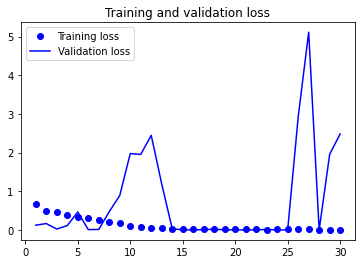

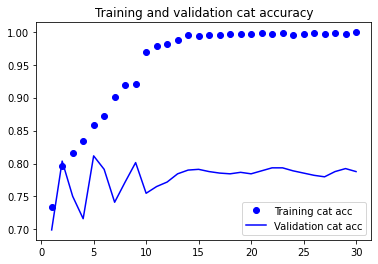

<Figure size 432x288 with 0 Axes>

In [ ]:
# display the loss and accuracy curves

import matplotlib.pyplot as plt

acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.figure()

plt.plot(epochs, acc, 'bo', label='Training cat acc')
plt.plot(epochs, val_acc, 'b', label='Validation cat acc')
plt.title('Training and validation cat accuracy')
plt.legend()
plt.figure()

In [ ]:
# Get the labels of the test images.

test_labels = test_batches.classes

In [ ]:
# We need these to plot the confusion matrix.
test_labels

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [ ]:
# Print the label associated with each class
test_batches.class_indices

{'bacterial': 0, 'normal': 1, 'viral': 2}

In [ ]:
# make a prediction
predictions = model.predict_generator(test_batches, steps=val_steps, verbose=1)

89/89 [==============================] - 13s 146ms/step


In [ ]:
test_labels.shape

(881,)

In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [ ]:
# argmax returns the index of the max value in a row
cm = confusion_matrix(test_labels, predictions.argmax(axis=1))

In [ ]:
test_batches.class_indices

{'bacterial': 0, 'normal': 1, 'viral': 2}

Confusion matrix, without normalization
[[334   9  75]
 [  1 227  10]
 [ 60  11 154]]


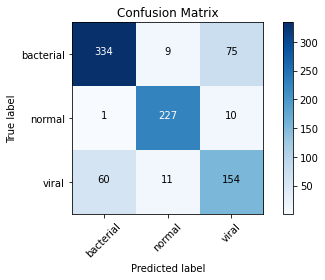

In [ ]:
# order shown above.
cm_plot_labels = ['bacterial', 'normal', 'viral']

plot_confusion_matrix(cm, cm_plot_labels, title='Confusion Matrix')

In [ ]:
# Get the filenames, labels and associated predictions

# This outputs the sequence in which the generator processed the test images
test_filenames = test_batches.filenames

# Get the true labels
y_true = test_batches.classes

# Get the predicted labels
y_pred = predictions.argmax(axis=1)

In [ ]:
from sklearn.metrics import classification_report

# Generate a classification report


report = classification_report(y_true, y_pred, target_names=cm_plot_labels)

print(report)


              precision    recall  f1-score   support

   bacterial       0.85      0.80      0.82       418
      normal       0.92      0.95      0.94       238
       viral       0.64      0.68      0.66       225

    accuracy                           0.81       881
   macro avg       0.80      0.81      0.81       881
weighted avg       0.81      0.81      0.81       881



# **End of model building and evaluation**

In [ ]:
model.save('model.h5')